# Neural rendering optimization: Fit FLAME mesh for improved DECA results

Contents:


-    Pytorch 3D installation, FLAME and rendering examples;
-   Get image pairs, of face ground truth image and render prediction (DECA output);
-   Rendering and optimising/training FLAME for better single subject rendering (improving DECA results)



## Install all dependencies/requirements

### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installations (Rest)
# After running this cell, restart runtime!

In [2]:
!pip install chumpy
!pip install facenet_pytorch # for face detection
#!pip install rembg[gpu] #cannot use for now -requires python 3.9 version
!pip install backgroundremover #for background removal
!pip uninstall -y Pillow
# install the new one
!pip install Pillow
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.0 MB/s 
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58285 sha256=331c41f845c5993c2665ad977df99e5d38d097475a7eb8fb3a1df6890d9874d9
  Stored in directory: /root/.cache/pip/wheels/59/68/de/5e0c5d77e573e8c150e69e07a25035e6b6a04952d6e1814dbc
Successfully built chumpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61 kB 4.5 MB/s 
     |████████████████████████████████| 48 kB 6.2 MB/s 
     |████████████████████████████████| 2.2 MB 15.5 MB/s 
     |██████

Found existing installation: Pillow 8.1.1
Uninstalling Pillow-8.1.1:
  Successfully uninstalled Pillow-8.1.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 9.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
backgroundremover 0.1.9 requires Pillow==8.1.1, but you have pillow 9.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### Install Pytorch3D

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

device = 'cuda'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0  1082k      0 --:--:-- --:--:-- --:--:-- 1082k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-o8vnt1qw
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-o8vnt1qw
  Running command git checkout -q 2bd65027ca5c3b87b77d4f05b8eacae58d8d106f
     |████████████████████████████████| 50 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 18.3 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.2-cp37-cp37m-linux_x86_64.whl size=31501470 sha256=85e5ca54d2739ee04e210002238474de3330ee5949b04e4dfce7801e2d577a7a
  Sto

In [2]:
%cd /content
import torch
import numpy as np
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes

from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras, 
    FoVPerspectiveCameras,
    PerspectiveCameras,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader,
    SoftPhongShader,
    SoftSilhouetteShader,
    BlendParams,
    TexturesVertex,
    TexturesUV
)

from pytorch3d.transforms import matrix_to_quaternion, quaternion_to_axis_angle, matrix_to_rotation_6d, axis_angle_to_matrix

/content


### Install FLAME

In [3]:
flame_model = '/content/drive/MyDrive/voca/FLAME2020.zip'
#!unzip [flame_model] -d /content/sample_data/
flame_path = "/content/FLAME/"
os.makedirs(flame_path, exist_ok=True)
!unzip /content/drive/MyDrive/voca/FLAME2020.zip -d $flame_path/ 

Archive:  /content/drive/MyDrive/voca/FLAME2020.zip
  inflating: /content/FLAME//female_model.pkl  
  inflating: /content/FLAME//generic_model.pkl  
  inflating: /content/FLAME//male_model.pkl  
  inflating: /content/FLAME//Readme.pdf  


In [4]:
# Get landmarks.npy which holds all the static and dynamic landmarks for FLAME
!wget "https://github.com/YadiraF/DECA/blob/master/data/landmark_embedding.npy?raw=true" -O /content/FLAME/landmark_embedding.npy

# Get texture info for texture regression
!wget "https://github.com/YadiraF/DECA/blob/master/data/texture_data_256.npy?raw=true" -O /content/FLAME/texture_data_256.npy

# Get template head model, to retrieve faces
!wget "https://raw.githubusercontent.com/YadiraF/DECA/master/data/head_template.obj" -O /content/FLAME/head_template.obj

--2022-06-02 13:04:24--  https://github.com/YadiraF/DECA/blob/master/data/landmark_embedding.npy?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/YadiraF/DECA/raw/master/data/landmark_embedding.npy [following]
--2022-06-02 13:04:24--  https://github.com/YadiraF/DECA/raw/master/data/landmark_embedding.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YadiraF/DECA/master/data/landmark_embedding.npy [following]
--2022-06-02 13:04:25--  https://raw.githubusercontent.com/YadiraF/DECA/master/data/landmark_embedding.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected

In [5]:
!cp /content/drive/MyDrive/FLAME_albedo_from_BFM.npz /content/FLAME/FLAME_albedo_from_BFM.npz # get texture FLAME_albedo map from BFM model

In [8]:
#Sparse git clone of SMLPX library
!pip install github-clone
!ghclone "https://github.com/vchoutas/smplx/tree/master/smplx" # library from Vasilis Choutas with FLAME library 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'smplx'...
done.


In [9]:
# @title old FLAME.py
%%writefile /content/old.py
"""
FLAME Layer: Implementation of the 3D Statistical Face model in PyTorch

It is designed in a way to directly plug in as a decoder layer in a 
Deep learning framework for training and testing

It can also be used for 2D or 3D optimisation applications

Author: Soubhik Sanyal
Copyright (c) 2019, Soubhik Sanyal
All rights reserved.

Max-Planck-Gesellschaft zur Foerderung der Wissenschaften e.V. (MPG) is holder of all proprietary rights on this
computer program.
You can only use this computer program if you have closed a license agreement with MPG or you get the right to use
the computer program from someone who is authorized to grant you that right.
Any use of the computer program without a valid license is prohibited and liable to prosecution.
Copyright 2019 Max-Planck-Gesellschaft zur Foerderung der Wissenschaften e.V. (MPG). acting on behalf of its
Max Planck Institute for Intelligent Systems and the Max Planck Institute for Biological Cybernetics.
All rights reserved.

More information about FLAME is available at http://flame.is.tue.mpg.de.

For questions regarding the PyTorch implementation please contact soubhik.sanyal@tuebingen.mpg.de
"""
# Modified from smplx code [https://github.com/vchoutas/smplx] for FLAME
import numpy as np
import torch
import torch.nn as nn
import pickle
from smplx.lbs import lbs, batch_rodrigues, vertices2landmarks, find_dynamic_lmk_idx_and_bcoords
from smplx.utils import Struct, to_tensor, to_np, rot_mat_to_euler


class FLAME(nn.Module):
    """
    Given flame parameters this class generates a differentiable FLAME function
    which outputs the a mesh and 3D facial landmarks
    """
    def __init__(self, config):
        super(FLAME, self).__init__()
        print("creating the FLAME Decoder")
        with open(config.flame_model_path, 'rb') as f:
            self.flame_model = Struct(**pickle.load(f, encoding='latin1'))
        self.NECK_IDX = 1
        self.batch_size = config.batch_size
        self.dtype = torch.float32
        self.use_face_contour = config.use_face_contour
        self.faces = self.flame_model.f
        self.register_buffer('faces_tensor',
                             to_tensor(to_np(self.faces, dtype=np.int64),
                                       dtype=torch.long))

        # Fixing remaining Shape betas
        # There are total 300 shape parameters to control FLAME; But one can use the first few parameters to express
        # the shape. For example 100 shape parameters are used for RingNet project 
        default_shape = torch.zeros([self.batch_size, 300-config.shape_params],
                                            dtype=self.dtype, requires_grad=False)
        self.register_parameter('shape_betas', nn.Parameter(default_shape,
                                                      requires_grad=False))

        # Fixing remaining expression betas
        # There are total 100 shape expression parameters to control FLAME; But one can use the first few parameters to express
        # the expression. For example 50 expression parameters are used for RingNet project 
        default_exp = torch.zeros([self.batch_size, 100 - config.expression_params],
                                    dtype=self.dtype, requires_grad=False)
        self.register_parameter('expression_betas', nn.Parameter(default_exp,
                                                            requires_grad=False))

        # Eyeball and neck rotation
        default_eyball_pose = torch.zeros([self.batch_size, 6],
                                    dtype=self.dtype, requires_grad=False)
        self.register_parameter('eye_pose', nn.Parameter(default_eyball_pose,
                                                            requires_grad=False))

        default_neck_pose = torch.zeros([self.batch_size, 3],
                                    dtype=self.dtype, requires_grad=False)
        self.register_parameter('neck_pose', nn.Parameter(default_neck_pose,
                                                            requires_grad=False))

        # Fixing 3D translation since we use translation in the image plane

        self.use_3D_translation = config.use_3D_translation

        default_transl = torch.zeros([self.batch_size, 3],
                                     dtype=self.dtype, requires_grad=False)
        self.register_parameter(
            'transl',
            nn.Parameter(default_transl, requires_grad=False))

        # The vertices of the template model
        self.register_buffer('v_template',
                             to_tensor(to_np(self.flame_model.v_template),
                                       dtype=self.dtype))

        # The shape components
        shapedirs = self.flame_model.shapedirs
        # The shape components
        self.register_buffer(
            'shapedirs',
            to_tensor(to_np(shapedirs), dtype=self.dtype))

        j_regressor = to_tensor(to_np(
            self.flame_model.J_regressor), dtype=self.dtype)
        self.register_buffer('J_regressor', j_regressor)

        # Pose blend shape basis
        num_pose_basis = self.flame_model.posedirs.shape[-1]
        posedirs = np.reshape(self.flame_model.posedirs, [-1, num_pose_basis]).T
        self.register_buffer('posedirs',
                             to_tensor(to_np(posedirs), dtype=self.dtype))

        # indices of parents for each joints
        parents = to_tensor(to_np(self.flame_model.kintree_table[0])).long()
        parents[0] = -1
        self.register_buffer('parents', parents)

        self.register_buffer('lbs_weights',
                             to_tensor(to_np(self.flame_model.weights), dtype=self.dtype))

        # Static and Dynamic Landmark embeddings for FLAME

        with open(config.static_landmark_embedding_path, 'rb') as f:
            static_embeddings = Struct(**pickle.load(f, encoding='latin1'))

        lmk_faces_idx = (static_embeddings.lmk_face_idx).astype(np.int64)
        self.register_buffer('lmk_faces_idx',
                             torch.tensor(lmk_faces_idx, dtype=torch.long))
        lmk_bary_coords = static_embeddings.lmk_b_coords
        self.register_buffer('lmk_bary_coords',
                             torch.tensor(lmk_bary_coords, dtype=self.dtype))

        if self.use_face_contour:
            conture_embeddings = np.load(config.dynamic_landmark_embedding_path,
                allow_pickle=True, encoding='latin1')
            conture_embeddings = conture_embeddings[()]
            dynamic_lmk_faces_idx = np.array(conture_embeddings['lmk_face_idx']).astype(np.int64)
            dynamic_lmk_faces_idx = torch.tensor(
                dynamic_lmk_faces_idx,
                dtype=torch.long)
            self.register_buffer('dynamic_lmk_faces_idx',
                                 dynamic_lmk_faces_idx)

            dynamic_lmk_bary_coords = conture_embeddings['lmk_b_coords']
            dynamic_lmk_bary_coords = torch.tensor(
                dynamic_lmk_bary_coords, dtype=self.dtype)
            self.register_buffer('dynamic_lmk_bary_coords',
                                 dynamic_lmk_bary_coords)

            neck_kin_chain = []
            curr_idx = torch.tensor(self.NECK_IDX, dtype=torch.long)
            while curr_idx != -1:
                neck_kin_chain.append(curr_idx)
                curr_idx = self.parents[curr_idx]
            self.register_buffer('neck_kin_chain',
                                 torch.stack(neck_kin_chain))

    def _find_dynamic_lmk_idx_and_bcoords(self, vertices, pose, dynamic_lmk_faces_idx,
                                         dynamic_lmk_b_coords,
                                         neck_kin_chain, dtype=torch.float32):
        """
            Selects the face contour depending on the reletive position of the head
            Input:
                vertices: N X num_of_vertices X 3
                pose: N X full pose
                dynamic_lmk_faces_idx: The list of contour face indexes
                dynamic_lmk_b_coords: The list of contour barycentric weights
                neck_kin_chain: The tree to consider for the relative rotation
                dtype: Data type
            return:
                The contour face indexes and the corresponding barycentric weights
            Source: Modified for batches from https://github.com/vchoutas/smplx
        """

        batch_size = vertices.shape[0]

        aa_pose = torch.index_select(pose.view(batch_size, -1, 3), 1,
                                     neck_kin_chain)
        rot_mats = batch_rodrigues(
            aa_pose.view(-1, 3), dtype=dtype).view(batch_size, -1, 3, 3)

        rel_rot_mat = torch.eye(3, device=vertices.device,
                                dtype=dtype).unsqueeze_(dim=0).expand(batch_size, -1, -1)
        for idx in range(len(neck_kin_chain)):
            rel_rot_mat = torch.bmm(rot_mats[:, idx], rel_rot_mat)

        y_rot_angle = torch.round(
            torch.clamp(-rot_mat_to_euler(rel_rot_mat) * 180.0 / np.pi,
                        max=39)).to(dtype=torch.long)
        neg_mask = y_rot_angle.lt(0).to(dtype=torch.long)
        mask = y_rot_angle.lt(-39).to(dtype=torch.long)
        neg_vals = mask * 78 + (1 - mask) * (39 - y_rot_angle)
        y_rot_angle = (neg_mask * neg_vals +
                       (1 - neg_mask) * y_rot_angle)

        dyn_lmk_faces_idx = torch.index_select(dynamic_lmk_faces_idx,
                                               0, y_rot_angle)
        dyn_lmk_b_coords = torch.index_select(dynamic_lmk_b_coords,
                                              0, y_rot_angle)

        return dyn_lmk_faces_idx, dyn_lmk_b_coords

    def forward(self, shape_params=None, expression_params=None, pose_params=None, neck_pose=None, eye_pose=None, transl=None):
        """
            Input:
                shape_params: N X number of shape parameters
                expression_params: N X number of expression parameters
                pose_params: N X number of pose parameters
            return:
                vertices: N X V X 3
                landmarks: N X number of landmarks X 3
        """
        betas = torch.cat([shape_params,self.shape_betas, expression_params, self.expression_betas], dim=1)
        neck_pose = (neck_pose if neck_pose is not None else self.neck_pose)
        eye_pose = (eye_pose if eye_pose is not None else self.eye_pose)
        transl = (transl if transl is not None else self.transl)
        full_pose = torch.cat([pose_params[:,:3], neck_pose, pose_params[:,3:], eye_pose], dim=1)
        template_vertices = self.v_template.unsqueeze(0).repeat(self.batch_size, 1, 1)

        vertices, _ = lbs(betas, full_pose, template_vertices,
                               self.shapedirs, self.posedirs,
                               self.J_regressor, self.parents,
                               self.lbs_weights, dtype=self.dtype)

        lmk_faces_idx = self.lmk_faces_idx.unsqueeze(dim=0).repeat(
            self.batch_size, 1)
        lmk_bary_coords = self.lmk_bary_coords.unsqueeze(dim=0).repeat(
            self.batch_size, 1, 1)
        if self.use_face_contour:

            dyn_lmk_faces_idx, dyn_lmk_bary_coords = self._find_dynamic_lmk_idx_and_bcoords(
                vertices, full_pose, self.dynamic_lmk_faces_idx,
                self.dynamic_lmk_bary_coords,
                self.neck_kin_chain, dtype=self.dtype)

            lmk_faces_idx = torch.cat([dyn_lmk_faces_idx, lmk_faces_idx], 1)
            lmk_bary_coords = torch.cat(
                [dyn_lmk_bary_coords, lmk_bary_coords], 1)

        landmarks = vertices2landmarks(vertices, self.faces_tensor,
                                             lmk_faces_idx,
                                             lmk_bary_coords)

        if self.use_3D_translation:
            landmarks += transl.unsqueeze(dim=1)
            vertices += transl.unsqueeze(dim=1)

        return vertices, landmarks

Overwriting /content/old.py


In [10]:
# @title New FLAME.py as Module.nn
%%writefile /content/smplx/FLAME.py
# -*- coding: utf-8 -*-
#
# Max-Planck-Gesellschaft zur Förderung der Wissenschaften e.V. (MPG) is
# holder of all proprietary rights on this computer program.
# Using this computer program means that you agree to the terms 
# in the LICENSE file included with this software distribution. 
# Any use not explicitly granted by the LICENSE is prohibited.
#
# Copyright©2019 Max-Planck-Gesellschaft zur Förderung
# der Wissenschaften e.V. (MPG). acting on behalf of its Max Planck Institute
# for Intelligent Systems. All rights reserved.
#
# For comments or questions, please email us at deca@tue.mpg.de
# For commercial licensing contact, please contact ps-license@tuebingen.mpg.de

import torch
import torch.nn as nn
import numpy as np
import pickle
import torch.nn.functional as F
import sys
sys.path.append("/content/smplx/")
from .lbs import lbs, batch_rodrigues, vertices2landmarks, rot_mat_to_euler

def to_tensor(array, dtype=torch.float32):
    if 'torch.tensor' not in str(type(array)):
        return torch.tensor(array, dtype=dtype)
def to_np(array, dtype=np.float32):
    if 'scipy.sparse' in str(type(array)):
        array = array.todense()
    return np.array(array, dtype=dtype)

class Struct(object):
    def __init__(self, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)

class FLAME(nn.Module):
    """
    borrowed from https://github.com/soubhiksanyal/FLAME_PyTorch/blob/master/FLAME.py
    Given flame parameters this class generates a differentiable FLAME function
    which outputs the a mesh and 2D/3D facial landmarks
    """
    def __init__(self, config):
        super(FLAME, self).__init__()
        print("creating the FLAME Decoder")
        with open(config.flame_model_path, 'rb') as f:
            ss = pickle.load(f, encoding='latin1')
            flame_model = Struct(**ss)

        self.dtype = torch.float32
        self.register_buffer('faces_tensor', to_tensor(to_np(flame_model.f, dtype=np.int64), dtype=torch.long))
        # The vertices of the template model
        self.register_buffer('v_template', to_tensor(to_np(flame_model.v_template), dtype=self.dtype))
        # The shape components and expression
        shapedirs = to_tensor(to_np(flame_model.shapedirs), dtype=self.dtype)
        shapedirs = torch.cat([shapedirs[:,:,:config.n_shape], shapedirs[:,:,300:300+config.n_exp]], 2)
        self.register_buffer('shapedirs', shapedirs)
        # The pose components
        num_pose_basis = flame_model.posedirs.shape[-1]
        posedirs = np.reshape(flame_model.posedirs, [-1, num_pose_basis]).T
        self.register_buffer('posedirs', to_tensor(to_np(posedirs), dtype=self.dtype))
        # 
        self.register_buffer('J_regressor', to_tensor(to_np(flame_model.J_regressor), dtype=self.dtype))
        parents = to_tensor(to_np(flame_model.kintree_table[0])).long(); parents[0] = -1
        self.register_buffer('parents', parents)
        self.register_buffer('lbs_weights', to_tensor(to_np(flame_model.weights), dtype=self.dtype))

        # Fixing Eyeball and neck rotation
        default_eyball_pose = torch.zeros([1, 6], dtype=self.dtype, requires_grad=False)
        self.register_parameter('eye_pose', nn.Parameter(default_eyball_pose,
                                                         requires_grad=False))
        default_neck_pose = torch.zeros([1, 3], dtype=self.dtype, requires_grad=False)
        self.register_parameter('neck_pose', nn.Parameter(default_neck_pose,
                                                          requires_grad=False))

        # Static and Dynamic Landmark embeddings for FLAME
        lmk_embeddings = np.load(config.flame_lmk_embedding_path, allow_pickle=True, encoding='latin1')
        lmk_embeddings = lmk_embeddings[()]
        self.register_buffer('lmk_faces_idx', torch.from_numpy(lmk_embeddings['static_lmk_faces_idx']).long())
        self.register_buffer('lmk_bary_coords', torch.from_numpy(lmk_embeddings['static_lmk_bary_coords']).to(self.dtype))
        self.register_buffer('dynamic_lmk_faces_idx', lmk_embeddings['dynamic_lmk_faces_idx'].long())
        self.register_buffer('dynamic_lmk_bary_coords', lmk_embeddings['dynamic_lmk_bary_coords'].to(self.dtype))
        self.register_buffer('full_lmk_faces_idx', torch.from_numpy(lmk_embeddings['full_lmk_faces_idx']).long())
        self.register_buffer('full_lmk_bary_coords', torch.from_numpy(lmk_embeddings['full_lmk_bary_coords']).to(self.dtype))

        neck_kin_chain = []; NECK_IDX=1
        curr_idx = torch.tensor(NECK_IDX, dtype=torch.long)
        while curr_idx != -1:
            neck_kin_chain.append(curr_idx)
            curr_idx = self.parents[curr_idx]
        self.register_buffer('neck_kin_chain', torch.stack(neck_kin_chain))
        
    def _find_dynamic_lmk_idx_and_bcoords(self, pose, dynamic_lmk_faces_idx,
                                          dynamic_lmk_b_coords,
                                          neck_kin_chain, dtype=torch.float32):
        """
            Selects the face contour depending on the reletive position of the head
            Input:
                vertices: N X num_of_vertices X 3
                pose: N X full pose
                dynamic_lmk_faces_idx: The list of contour face indexes
                dynamic_lmk_b_coords: The list of contour barycentric weights
                neck_kin_chain: The tree to consider for the relative rotation
                dtype: Data type
            return:
                The contour face indexes and the corresponding barycentric weights
        """

        batch_size = pose.shape[0]

        aa_pose = torch.index_select(pose.view(batch_size, -1, 3), 1,
                                     neck_kin_chain)
        rot_mats = batch_rodrigues(
            aa_pose.view(-1, 3), dtype=dtype).view(batch_size, -1, 3, 3)

        rel_rot_mat = torch.eye(3, device=pose.device,
                                dtype=dtype).unsqueeze_(dim=0).expand(batch_size, -1, -1)
        for idx in range(len(neck_kin_chain)):
            rel_rot_mat = torch.bmm(rot_mats[:, idx], rel_rot_mat)

        y_rot_angle = torch.round(
            torch.clamp(rot_mat_to_euler(rel_rot_mat) * 180.0 / np.pi,
                        max=39)).to(dtype=torch.long)

        neg_mask = y_rot_angle.lt(0).to(dtype=torch.long)
        mask = y_rot_angle.lt(-39).to(dtype=torch.long)
        neg_vals = mask * 78 + (1 - mask) * (39 - y_rot_angle)
        y_rot_angle = (neg_mask * neg_vals +
                       (1 - neg_mask) * y_rot_angle)

        dyn_lmk_faces_idx = torch.index_select(dynamic_lmk_faces_idx,
                                               0, y_rot_angle)
        dyn_lmk_b_coords = torch.index_select(dynamic_lmk_b_coords,
                                              0, y_rot_angle)
        return dyn_lmk_faces_idx, dyn_lmk_b_coords

    def _vertices2landmarks(self, vertices, faces, lmk_faces_idx, lmk_bary_coords):
        """
            Calculates landmarks by barycentric interpolation
            Input:
                vertices: torch.tensor NxVx3, dtype = torch.float32
                    The tensor of input vertices
                faces: torch.tensor (N*F)x3, dtype = torch.long
                    The faces of the mesh
                lmk_faces_idx: torch.tensor N X L, dtype = torch.long
                    The tensor with the indices of the faces used to calculate the
                    landmarks.
                lmk_bary_coords: torch.tensor N X L X 3, dtype = torch.float32
                    The tensor of barycentric coordinates that are used to interpolate
                    the landmarks

            Returns:
                landmarks: torch.tensor NxLx3, dtype = torch.float32
                    The coordinates of the landmarks for each mesh in the batch
        """
        # Extract the indices of the vertices for each face
        # NxLx3
        batch_size, num_verts = vertices.shape[:dd2]
        lmk_faces = torch.index_select(faces, 0, lmk_faces_idx.view(-1)).view(
            1, -1, 3).view(batch_size, lmk_faces_idx.shape[1], -1)

        lmk_faces += torch.arange(batch_size, dtype=torch.long).view(-1, 1, 1).to(
            device=vertices.device) * num_verts

        lmk_vertices = vertices.view(-1, 3)[lmk_faces]
        landmarks = torch.einsum('blfi,blf->bli', [lmk_vertices, lmk_bary_coords])
        return landmarks

    def seletec_3d68(self, vertices):
        landmarks3d = vertices2landmarks(vertices, self.faces_tensor,
                                       self.full_lmk_faces_idx.repeat(vertices.shape[0], 1),
                                       self.full_lmk_bary_coords.repeat(vertices.shape[0], 1, 1))
        return landmarks3d

    def forward(self, shape_params=None, expression_params=None, pose_params=None, eye_pose_params=None):
        """
            Input:
                shape_params: N X number of shape parameters
                expression_params: N X number of expression parameters
                pose_params: N X number of pose parameters (6)
            return:d
                vertices: N X V X 3
                landmarks: N X number of landmarks X 3
        """
        batch_size = shape_params.shape[0]
        if pose_params is None:
            pose_params = self.eye_pose.expand(batch_size, -1)
        if eye_pose_params is None:
            eye_pose_params = self.eye_pose.expand(batch_size, -1)
        betas = torch.cat([shape_params, expression_params], dim=1)
        full_pose = torch.cat([pose_params[:, :3], self.neck_pose.expand(batch_size, -1), pose_params[:, 3:], eye_pose_params], dim=1)
        template_vertices = self.v_template.unsqueeze(0).expand(batch_size, -1, -1)

        vertices, _ = lbs(betas, full_pose, template_vertices,
                          self.shapedirs, self.posedirs,
                          self.J_regressor, self.parents,
                          self.lbs_weights, dtype=self.dtype)

        lmk_faces_idx = self.lmk_faces_idx.unsqueeze(dim=0).expand(batch_size, -1)
        lmk_bary_coords = self.lmk_bary_coords.unsqueeze(dim=0).expand(batch_size, -1, -1)
        
        dyn_lmk_faces_idx, dyn_lmk_bary_coords = self._find_dynamic_lmk_idx_and_bcoords(
            full_pose, self.dynamic_lmk_faces_idx,
            self.dynamic_lmk_bary_coords,
            self.neck_kin_chain, dtype=self.dtype)
        lmk_faces_idx = torch.cat([dyn_lmk_faces_idx, lmk_faces_idx], 1)
        lmk_bary_coords = torch.cat([dyn_lmk_bary_coords, lmk_bary_coords], 1)

        landmarks2d = vertices2landmarks(vertices, self.faces_tensor,
                                       lmk_faces_idx,
                                       lmk_bary_coords)
        bz = vertices.shape[0]
        landmarks3d = vertices2landmarks(vertices, self.faces_tensor,
                                       self.full_lmk_faces_idx.repeat(bz, 1),
                                       self.full_lmk_bary_coords.repeat(bz, 1, 1))
        return vertices, landmarks2d, landmarks3d

class FLAMETex(nn.Module):
    """
    FLAME texture:
    https://github.com/TimoBolkart/TF_FLAME/blob/ade0ab152300ec5f0e8555d6765411555c5ed43d/sample_texture.py#L64
    FLAME texture converted from BFM:
    https://github.com/TimoBolkart/BFM_to_FLAME
    """
    def __init__(self, config):
        super(FLAMETex, self).__init__()
        if config.tex_type == 'BFM':
            mu_key = 'MU'
            pc_key = 'PC'
            n_pc = 199
            tex_path = config.tex_path
            tex_space = np.load(tex_path)
            texture_mean = tex_space[mu_key].reshape(1, -1)
            texture_basis = tex_space[pc_key].reshape(-1, n_pc)

        elif config.tex_type == 'FLAME':
            mu_key = 'mean'
            pc_key = 'tex_dir'
            n_pc = 200
            tex_path = config.flame_tex_path
            tex_space = np.load(tex_path)
            texture_mean = tex_space[mu_key].reshape(1, -1)/255.
            texture_basis = tex_space[pc_key].reshape(-1, n_pc)/255.
        else:
            print('texture type ', config.tex_type, 'not exist!')
            raise NotImplementedError

        n_tex = config.n_tex
        num_components = texture_basis.shape[1]
        texture_mean = torch.from_numpy(texture_mean).float()[None,...]
        texture_basis = torch.from_numpy(texture_basis[:,:n_tex]).float()[None,...]
        self.register_buffer('texture_mean', texture_mean)
        self.register_buffer('texture_basis', texture_basis)

    def forward(self, texcode):
        '''
        texcode: [batchsize, n_tex]
        texture: [bz, 3, 256, 256], range: 0-1
        '''
        texture = self.texture_mean + (self.texture_basis*texcode[:,None,:]).sum(-1)
        texture = texture.reshape(texcode.shape[0], 512, 512, 3).permute(0,3,1,2)
        texture = F.interpolate(texture, [256, 256])
        texture = texture[:,[2,1,0], :,:]
        return texture 

Writing /content/smplx/FLAME.py


## Image (GT) and Render(Prediction) data

In [11]:
from PIL import Image
import numpy as np
import cv2
import torch
from torchvision import transforms
from facenet_pytorch import MTCNN as mtcnn

def pad(img, new_size, old_size, color=[255, 255, 255]):
  padded_img = np.full((new_size,new_size, 3), fill_value=tuple(color))

  # compute center offset - same for square images
  x_center = int((new_size - old_size) // 2)
  y_center = int((new_size - old_size) // 2)

  # copy img image into center of result image
  padded_img[y_center:y_center+ old_size, 
        x_center:x_center+old_size] = img
  return padded_img

def remove_background(img="", img_path="", color=""):
  ''' Remove background from image array or imgage path
      img: image 0-255, uint8, rgb, [h, w, 3]
      img_path: path to image
      return: detected box
  '''
  try:
    #img = np.uint8(img)
    cropped_img = Image.fromarray(img)
  except:
    print("Img array was not loaded")
    cropped_img = Image.open(img_path)
    
  temp_path = "/content/sample_data/temp.jpg"
  temp2_path = "/content/sample_data/temp2.jpg"
  cropped_img.save(temp_path)
  !backgroundremover -i $temp_path -o $temp2_path
  img = np.asarray(Image.open(temp2_path).convert('RGB'))
  return img
  

def crop_img(img_path="", img=""):
  ''' Detect face and crop image
      img_path: path to image
      return: detected box
  '''
  try:
    temp_img = img.copy()
    img = img.copy()
  except:
    temp_img = np.asarray(Image.open(img_path).convert('RGB'))
    img = np.asarray(Image.open(img_path).convert('RGB'))
  face_detector = mtcnn(keep_all=True)
  out = face_detector.detect(temp_img)
  print(out)
  if out[0] is None:
    print("No face is detected")
    return img
  else:
    bbox = out[0][0].squeeze().astype(int)
    y1 = bbox[0]
    y2 = bbox[2]
    x1 = bbox[1]
    x2 = bbox[3]
    dx = int((x2-x1)/4) # use this to catch the shoulders
    dy = int((y2-y1)/4) # and neck and hair
    cropped_img = img.copy()[abs(x1-dx):abs(x2+dx), abs(y1-dy):abs(y2+dy)]
    return cropped_img

def img_to_tensor(img_path):
  ''' img should be a float value [0,1] '''
  img = np.asarray(Image.open(img_path).convert('RGB'))
  img = img / 255 #normalized like the render
  tensor = torch.Tensor(img).unsqueeze(0)
  return tensor


In [12]:
def load_img(img_path, cropped=True, img_size=256,
             background_remove=False, scale=1, pad_color=[255,255,255],
             render_size=200, replace=False):
    ''' Load an image as a torch sensor. This is used to preprocess gt images 
        for mesh fitting
        img_path: path to image (str)
        cropped: crop image/face detection (boolean)
        img_size: maximum h and w of image (int)
        background_remove: remove background/replace with transparent background(boolean)
        scale: zoom in/zoom out effect of face in image frame (float: [0-1])
        pad_color: RGB channel for image padding (int array: (3,1))
        render_size: this should match the render size and corresponds to the size of the face in the image frame (int)
    '''


    if cropped:
      img = crop_img(img_path)
    else:
      img = np.asarray(Image.open(img_path).convert('RGB'))
    h, w, _ = img.shape
    max_dim = max(h, w)

    if background_remove:
      img = remove_background(img)
      img [(img == 1)] = 255
      img [(img == 0)] = 255

    try:
      scaled_size = int((scale) * img_size) # face imgs of only squares
      img = cv2.resize(img, (scaled_size, scaled_size), interpolation=cv2.INTER_AREA)
    except:
      print("Scale value needs to be a float value between (0-1]")



    
    img = pad(img, new_size=img_size, old_size=scaled_size, color=pad_color)

    
    img = img / 255 #normalized like the render
    if replace:
      img_path = str(img_path.split(".")[:-1][0]) + ".png"
      plt.imsave(img_path, img)
    tensor = torch.Tensor(img).unsqueeze(0)
    #tensor = tensor.to(torch.float32)
          
    return tensor

In [13]:
# Download data

male_dataset = "https://www.dropbox.com/sh/56osnf7uohbxg9u/AAAHJUgA_IhOTqB64W7BtuSya?dl=1"
female_dataset = ""
sample_dataset_path = "/content/sample_dataset/"
!wget {male_dataset} -O /content/dataset # male dataset (lewis_hamilton)
!unzip /content/dataset -d {sample_dataset_path}

'''
# or just access via google drive
!cp -r /content/drive/MyDrive/deca/sample_dataset /content/sample_dataset
sample_dataset_path = "/content/drive/MyDrive/deca/sample_dataset"
'''

--2022-06-02 13:17:23--  https://www.dropbox.com/sh/56osnf7uohbxg9u/AAAHJUgA_IhOTqB64W7BtuSya?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/56osnf7uohbxg9u/AAAHJUgA_IhOTqB64W7BtuSya [following]
--2022-06-02 13:17:23--  https://www.dropbox.com/sh/dl/56osnf7uohbxg9u/AAAHJUgA_IhOTqB64W7BtuSya
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3a893cd42b82063fcd4872e433.dl.dropboxusercontent.com/zip_download_get/BJ0XgMmUuPSnXnICLlS9xpH8CeL6-xoiXVHO2vR8KT-sVGqcgkpivtBUJDidRABGRuIcOsEbw0rqD-gJAs4EO5YlWJ_4rbzc1H6iBQyqFJP7Jw?dl=1# [following]
--2022-06-02 13:17:24--  https://uc3a893cd42b82063fcd4872e433.dl.dropboxusercontent.com/zip_download_get/BJ0XgMmUuPSnXnICLlS9xpH8CeL6-xoiXVHO2vR8KT-sVGqcgkpivtBUJDidRABGRuIcOsEbw0rqD

'\n# or just access via google drive\n!cp -r /content/drive/MyDrive/deca/sample_dataset /content/sample_dataset\nsample_dataset_path = "/content/drive/MyDrive/deca/sample_dataset"\n'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


(array([[546.26355, 110.51968, 742.31775, 355.1156 ]], dtype=float32), array([0.9999808], dtype=float32))
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/content/sample_data/temp2.jpg
Downloading...
From: https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: /root/.u2net/u2net.pth
100% 176M/176M [00:01<00:00, 112MB/s]


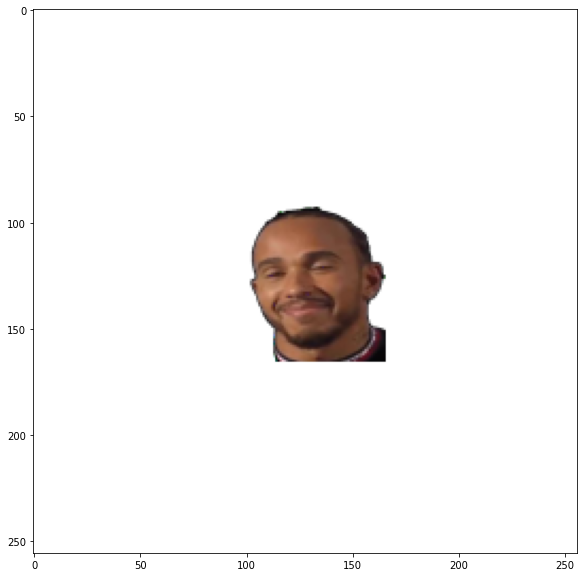

In [14]:
#example image
path = "/content/sample_dataset/lewis/lewis_frame0015.jpg"
img = load_img(path, background_remove=True, replace=False, scale=0.3)
img = img.squeeze(0).detach().cpu().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(img)

##  Define and render an example mesh

### Define Camera View

In [15]:
# Define camera matrix C
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    FoVPerspectiveCameras
)
device = torch.device("cuda:0")
R, T = look_at_view_transform(dist=0.6, elev=0, azim=0) # 0 elevation , and 0 azimuth
C = FoVPerspectiveCameras(device=device, R=R, T=T)

### Define Phong renderer

In [16]:
# define renderer

from pytorch3d.renderer import  (MeshRenderer, MeshRasterizer, SoftPhongShader,
    PointLights, Materials, RasterizationSettings,BlendParams
)

def get_phong_renderer(C_init, 
                      sigma=1.0e-4, 
                      gamma=1.0e-7, 
                      faces_per_pixel=50,
                      img_size=256,
                       blur_radius=1):
  
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

  materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0)
  
  blend_params = BlendParams(background_color=(1,1,1), sigma=sigma, gamma=gamma)
  if blur_radius is not 0:
      blur_radius= np.log(1. / 1e-4 - 1.) * blend_params.sigma
  else: blur_radius = 0

  raster_settings = RasterizationSettings(
      image_size=img_size, 
      blur_radius= blur_radius, 
      faces_per_pixel=faces_per_pixel, 
  )

  r = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=C_init,
          raster_settings=raster_settings
      ),
      shader=SoftPhongShader(
          device=device, 
          blend_params = blend_params,
          cameras=C_init,
          materials=materials,
          lights=lights
      )
  )

  return r

### Define Shilouette renderer



In [17]:
def get_silhoutte_renderer(C_init, 
                      sigma=1.0e-7, 
                      gamma=1.0e-1, 
                      faces_per_pixel=50,
                      img_size=256, 
                      blur_radius=1):
  
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

  materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0)
  
  blend_params = BlendParams(background_color=(1,1,1), sigma=sigma, gamma=gamma)
  if blur_radius is not 0:
    blur_radius= np.log(1. / 1e-4 - 1.) * blend_params.sigma
  else: blur_radius = 0

  raster_settings = RasterizationSettings(
      image_size=img_size, 
      blur_radius=blur_radius, 
      faces_per_pixel=faces_per_pixel, 
  )

  r = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=C_init, 
          raster_settings=raster_settings
      ),
      shader=SoftSilhouetteShader(blend_params=blend_params)
  )

  return r

### Render Example from saved (.obj) file

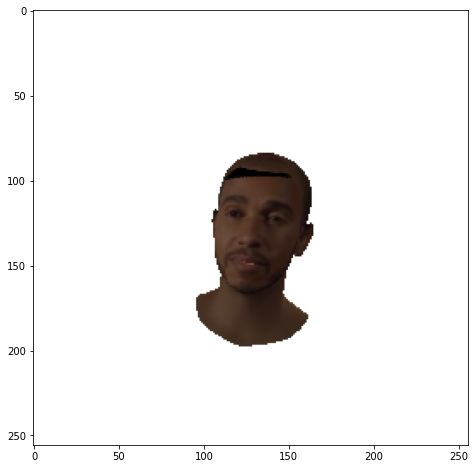

In [18]:
#@title Display example render via phong renderer
obj_filename = '/content/drive/MyDrive/deca/sample_dataset/DECA_results/lewis_frame0100/lewis_frame0100.obj'
device = torch.device("cuda:0")
mesh = load_objs_as_meshes([obj_filename], device=device)
render = get_phong_renderer(C, sigma=1.0e-6, gamma=1.0e-7, faces_per_pixel=1, blur_radius=0) # this returns a MeshRenderer object
I = render(mesh.to(device)).detach().cpu().numpy()


plt.figure(figsize=(8, 8))
plt.imshow(I[0, :, :, 0:3])

### Render example from saved FLAME parameters

In [ ]:
#Define config (with FLAME and general parameters)
from types import SimpleNamespace
config = {
    # FLAME
    'flame_model_path': '/content/FLAME/generic_model.pkl',  # acquire it from FLAME project page
    'flame_lmk_embedding_path': '/content/FLAME/landmark_embedding.npy',
    'tex_space_path': '/content/FLAME_texture.npz',  # acquire it from FLAME project page
    'n_cam': 3, # number of camera related parameters
    'n_shape': 100, # number of shape related parameters
    'n_exp': 50, # number of expression related parameters
    'n_pose': 6, # number of pose related parameters
    'n_tex': 50, # number of texture related parameters
    'n_light': 27, # number of light related parameters
    'useTex': True,
    'use_face_contour': True,
    'use_3D_translation': True,
    'tex_type': 'BFM', # change to FLAME (maybe)
    'tex_path': "/content/FLAME/FLAME_albedo_from_BFM.npz",
    'flame_tex_path': '/content/FLAME/texture_data_256.npy',
    'uv_size': 256,
    'obj_filename': "/content/FLAME/head_template.obj",  # get the head template - to use its faces
    'cropped_size': 256,
    'batch_size': 1,
    'image_size': 224,
    'e_lr': 0.005,
    'e_wd': 0.0001,
    'savefolder': '/content/FLAME_results',
    # weights of losses and reg terms
    'w_pho': 8,
    'w_lmks': 1,
    'w_shape_reg': 1e-4,
    'w_expr_reg': 1e-4,
    'w_pose_reg': 0,
}

## Get Image Pairs

### Utility Function

In [19]:
# auxiliary function: get render and ground truth images
from pytorch3d.transforms import axis_angle_to_matrix
from pytorch3d.structures import Meshes
def get_image_pair(prediction_path, data_path, frame_num, renderer, flame_model,
                   flameTex_model, T_uv=None, F_uv=None, verts_uvs=None,
                    pose=None, shape=None, exp=None, scale=0.3, silh=False, skip_gt=False):
  device = torch.device("cuda:0")
  img_size = 256
  name = str(data_path.split("/")[-1]) #e.g lewis
  img_gt_path = os.path.join(data_path, name + '_frame%04d.jpg' % frame_num)
  if not skip_gt:
    try:
      I_gt = load_img(img_path=img_gt_path, background_remove=True, scale=scale, img_size=img_size, cropped=True).to(device)
    except:
      print("Could not load ground truth image")
  else:
     I_gt = np.zeros((img_size, img_size, 3))
    
  # Use FLAME mesh
  #V, _, _ = flame_model.forward( shape_params=axis_angle_to_matrix(shape),
  # expression_params=axis_angle_to_matrix(exp), pose_params=axis_angle_to_matrix(pose),
  # eye_pose_params=None) # returns vertices, landmarks2d and landmarks3D

  #T = TexturesUV(maps=T_uv, faces_uvs=F_uv, verts_uvs=V_uv)
  #mesh = Meshes(V, F, T)

  '''
  # or just load your own (initial DECA mesh)
  obj_filename = os.path.join(os.path.join(prediction_path, name+ '_frame%04d' % frame_num) ,  name+ '_frame%04d.obj' % frame_num)
  mesh = load_objs_as_meshes([obj_filename], device=device)
  '''

  ### Use FLAMETex
  texture = flameTex_model.forward(texcode)

  '''
        texcode: [batchsize, n_tex]
        texture: [bz, 3, 256, 256], range: 0-1
        '''
  #mesh = Meshes (V, F, T)
  R, T = look_at_view_transform(dist=1, elev=0, azim=0)
  I_pred = renderer(mesh)  # pass it to the pytorch render

  if silh:
    I_gt = I_gt[:, :, :, 2]
    I_gt[I_gt==1] = 0
    I_gt[I_gt!=0] = 1
    I_pred = I_pred[:, :, :, 3]
  else:
    I_pred = I_pred[:, :, :, 0:3]
    
  return I_pred, I_gt

### Display training image pairs e.g GT & Prediction

In [20]:
R, T = look_at_view_transform(dist=0.65, elev=0, azim=0) # 0 elevation , and 0 azimuth
C = FoVPerspectiveCameras(device=device, R=R, T=T)
renderer_phong = get_phong_renderer(C, sigma=1.0e-7, gamma=1.0e-7, 
                                    faces_per_pixel=1, img_size=256)

frame_num = 7
prediction_path = "/content/drive/MyDrive/deca/sample_dataset/DECA_results" #path to folder with DECA predictions
data_path = "/content/drive/MyDrive/deca/sample_dataset/lewis" # path to folder with GT frames

I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=data_path,
                              frame_num=frame_num, renderer=renderer_phong, silh=False)
I_merged = torch.cat([ I_pred, I_gt], 2)[0].detach().cpu()
plt.figure(figsize=(10, 20))
plt.imshow(I_merged) #matplot displays background color as black

TypeError: ignored

### Save GT images (after background removal -  Time efficient)

In [ ]:
data_path = "/content/sample_dataset/lewis"
for frame in os.listdir(data_path):
  path = os.path.join(data_path, frame)
  img = load_img(path, background_remove=True, replace=True, scale=0.3)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


(array([[594.283  ,  97.60013, 789.3781 , 343.1941 ]], dtype=float32), array([1.], dtype=float32))
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/content/sample_data/temp2.jpg
(array([[614.09344,  88.5514 , 801.59296, 337.67157]], dtype=float32), array([0.99998], dtype=float32))
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/content/sample_data/temp2.jpg
(array([[629.51764,  77.06354, 817.79205, 321.37314]], dtype=float32), array([0.99996483], dtype=float32))
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.p

### Generate training renders

In [ ]:
render_log_dir = '/content/renders'
!rm -rf $render_log_dir
!mkdir $render_log_dir

path_to_objs = "/content/drive/MyDrive/deca/sample_dataset/DECA_results/"
frames = 200
prediction_path = path_to_objs
for frame in range(0, frames):
  I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=data_path,
                              frame_num=frame, renderer=renderer_phong, silh=False, skip_gt=True)
  I_pred = get_render(prediction_path=prediction_path, frame_num, renderer=renderer_phong, params)
  
  render = I_pred.detach().cpu().squeeze(0).numpy()
  savepath = os.path.join(render_log_dir,'_frame%04d.png' % frame)
  plt.imsave(savepath, render)



In [ ]:
# @title Function to get DECA renders
import sys
sys.path.append("/content/smplx/")
from smplx.FLAME import FLAME
from smplx.FLAME import FLAMETex
from pytorch3d.transforms import axis_angle_to_matrix
from pytorch3d.structures import load_obj

config = SimpleNamespace(**config) # to access dictionary keys with dot

flame_model = FLAME(config) # this is the FLAME model for the shape, pose, etc.
tex_flame_model = FLAMETex(config) # this is the FLAME model for texture
batch_size = 1
def get_render(prediction_path, frame_num, renderer, params):
  codedict = flame_deca_config
  vertices, landmarks2d, landmarks3d = flame_model(shape_params=codedict['shape'], expression_params=codedict['exp'], pose_params=codedict['pose'])
  if config.use_tex:
            albedo = tex_flame_model(codedict['tex'])
  else:
      albedo = torch.zeros([batch_size, 3, config.uv_size, config.uv_size], device=device) 
  landmarks3d_world = landmarks3d.clone()


  opdict = {
      "verts": vertices
  }

  # Get also faces
  verts, faces, aux = load_obj(config.obj_filename) # faces will be the same with the head template
  uvcoords = aux.verts_uvs[None, ...]      # (N, V, 2)
  uvfaces = faces.textures_idx[None, ...] # (N, F, 3)
  faces = faces.verts_idx[None,...]

  # Get texture uv


  '''
  vertices: [nv, 3], tensor
  texture: [3, h, w], tensor
  '''
  i = 0
  vertices = opdict['verts'][i].cpu().numpy()
  faces = faces[0].cpu().numpy()
  #texture = util.tensor2image(opdict['uv_texture_gt'][i])
  #uvcoords = self.render.raw_uvcoords[0].cpu().numpy()
  #uvfaces = self.render.uvfaces[0].cpu().numpy()
  # save coarse mesh, with texture and normal map
  normal_map = util.tensor2image(opdict['uv_detail_normals'][i]*0.5 + 0.5)
  util.write_obj(filename, vertices, faces, 
                  texture=texture, 
                  uvcoords=uvcoords, 
                  uvfaces=uvfaces, 
                  normal_map=normal_map)

ModuleNotFoundError: ignored

### Visualize Training renders (DECA results)

In [ ]:
# Visualize training renders (DECA predictions)
%cd /content/renders
!ffmpeg -framerate 20 -pattern_type glob -i '*.png' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  /content/training_data.mp4
%cd /content

In [ ]:

from IPython.display import HTML
from base64 import b64encode
mp4 = open('training_data.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Optimization/Training of FLAME

In [ ]:
sys.path.append("/content/smplx/")
from smplx.FLAME import FLAME
from smplx.FLAME import FLAMETex
#from FLAME import FLAMETex
#from smplx.body_models import FLAMELayer
#from body_models import FLAME
from pytorch3d.transforms import axis_angle_to_matrix

#!mv  '/content/FLAME/generic_model.pkl' "/content/FLAME/FLAME_NEUTRAL.pkl"
FLAME_model_path = '/content/FLAME/'
FLAME_uv_map_path = '/content/drive/MyDrive/deca/sample_dataset/DECA_results/lewis_frame0000/lewis_frame0000.obj'
#config["flame_tex_path"] = FLAME_uv_map_path

config = SimpleNamespace(**config) # to access dictionary keys with dot

flame_model = FLAME(config) # this is the FLAME model for the shape, pose, etc.
tex_flame_model = FLAMETex(config) # this is the FLAME model for texture

# texture map
_, faces, properties = load_obj(FLAME_uv_map_path, load_textures=True)
V_uv = properties.verts_uvs.unsqueeze(0).to(device)
F_uv = faces.textures_idx.unsqueeze(0).type(torch.long).to(device)
T_uv = torch.ones([1, 256, 256, 3]).to(device) # blank one


creating the FLAME Decoder


In [ ]:
rgb_log_dir = '/content/logs_phong_optimisation'
!rm -rf $rgb_log_dir
!mkdir $rgb_log_dir


### General parameters
max_frame = 40 # number of available training frames
img_size = 256 # image dimension of each training frame - SHOULD MATCH render (image) dimension
n_epochs = 50
prediction_path = "/content/sample_dataset/DECA_results" #path to folder with DECA predictions
data_path = "/content/sample_dataset/lewis" # path to folder with GT frames




### Define phong renderer
R, T = look_at_view_transform(dist=0.65, elev=0, azim=0) # 0 elevation , and 0 azimuth
C = FoVPerspectiveCameras(device=device, R=R, T=T)
renderer_phong = get_phong_renderer(C, sigma=1.0e-7, gamma=1.0e-7, 
                                    faces_per_pixel=1, img_size=img_size)


### Initialize FLAME optimization parameters 0
shape = torch.nn.Parameter(torch.zeros(img_size, config["shape_params"]).float().to(device), requires_grad=True)
tex = torch.nn.Parameter(torch.zeros(img_size, config["tex_params"]).float().to(device), requires_grad=True)
exp = torch.nn.Parameter(torch.zeros(img_size, config["expression_params"]).float().to(device), requires_grad=True)
pose = torch.nn.Parameter(torch.zeros(img_size, config["pose_params"]).float().to(device), requires_grad=True)
cam = torch.zeros(img_size, config["camera_params"]); cam[:, 0] = 5.
cam = torch.nn.Parameter(cam.float().to(device), requires_grad=True)
lights = torch.nn.Parameter(torch.zeros(img_size, 9, 3).float().to(device), requires_grad=True)

### Initialize FLAME parameters with DECA results
shape = torch.nn.Parameter(flame_deca_config["shape"], requires_grad=True)
tex = torch.nn.Parameter(flame_deca_config["tex"], requires_grad=True)
exp = torch.nn.Parameter(flame_deca_config["exp"], requires_grad=True)
pose = torch.nn.Parameter(flame_deca_config["pose"], requires_grad=True)
cam = torch.nn.Parameter(flame_deca_config["cam"], requires_grad=True)
lights = torch.nn.Parameter(flame_deca_config["light"], requires_grad=True)



### Initialize Texture optimization parameters
_, faces, properties = load_obj(FLAME_uv_map_path, load_textures=False) # set to False
V_uv = properties.verts_uvs.unsqueeze(0).to(device)
F_uv = faces.textures_idx.unsqueeze(0).type(torch.long).to(device)
texture_map_path = str(FLAME_uv_map_path.split(".")[:-1][0])+ ".png"
texture_map = np.asarray(Image.open(texture_map_path).convert("RGB"))
T_uv = torch.Tensor(texture_map).unsqueeze(0).to(device) # texture map is 1xHxWxChannels
T_uv = torch.nn.Parameter(T_uv, requires_grad=True) # texture - requires_grad is True by default




### Optimizers
face_opt = torch.optim.Adam([shape, tex, exp, pose, lights, cam], lr=2.0e-4)# face optimization
face_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(face_opt, 
                                            patience=2, verbose=True) # adjust learning rate
uv_opt = torch.optim.Adam([T_uv], lr=1.0e-2) # texture optimization uv map
uv_scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(uv_opt, 
                                                         patience=2,
                                                         verbose=True)

crit = torch.nn.L1Loss() # L1 loss for optimization

#### Dump

In [ ]:
import pickle
with open("/content/FLAME/generic_model.pkl", "rb") as f:
  flame_model = pickle.load(f, encoding='latin1')

In [ ]:
tx = np.load("/content/texture_data_256.npy", allow_pickle=True, encoding='latin1')

In [ ]:
tx[()].keys()

dict_keys(['img_size', 'ft', 'valid_pixel_b_coords', 'f', 'vt', 'y_coords', 'valid_pixel_ids', 'valid_pixel_3d_faces', 'x_coords'])

In [ ]:
flame_model.keys()

dict_keys(['f', 'J_regressor', 'kintree_table', 'J', 'bs_style', 'weights', 'posedirs', 'v_template', 'shapedirs', 'bs_type'])

In [ ]:
a = np.load("/content/landmark_embedding.npy", allow_pickle=True, encoding='latin1')
a = a[()]

In [ ]:
flame_params_path = "/content/drive/MyDrive/deca/sample_dataset/DECA_results/lewis_frame0001/flame_params.pkl"
import pickle as pkl
with open(flame_params_path, "rb") as f:
  flame_deca_config = pkl.load(f)

### Texture Optimization

In [ ]:
for epoch_id in range(0, n_epochs):
  I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=data_path,
                              frame_num=1, renderer=renderer_phong, silh=False)
  I_merged = torch.cat([I_pred, I_gt], 2)[0].detach().cpu().clip(0, 1).numpy()
  plt.imsave(os.path.join(rgb_log_dir, '%04d.png' % epoch_id), I_merged)

  train_frames = np.random.randint(low=0, high=max_frame, size=(5))#max_frame))

  total_loss = 0 # initial loss is 0 

  for frame_num in train_frames:

    I_pred, I_gt = get_image_pair(prediction_path=prediction_path, data_path=data_path,
                              frame_num=frame_num, renderer=renderer_phong, silh=False)

    loss = crit(I_gt.to(device), I_pred.to(device))
    loss.requires_grad = True
    total_loss += float(loss)

    face_opt.zero_grad()
    uv_opt.zero_grad()
    loss.backward()
    uv_opt.step()
    face_opt.step()

  print("Total L1 loss: %f" % total_loss)
  face_scheduler.step(total_loss)
  uv_scheduler.step(total_loss)


In [ ]:
# @title generate texture optimisation video
%cd /content/logs_phong_optimisation
!ffmpeg -framerate 1 -pattern_type glob -i '*.png' -vcodec h264 -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"  /content/texture_optimisation.mp4
%cd /content

In [ ]:
# @title Show texture optimisation process
from IPython.display import HTML
from base64 import b64encode
mp4 = open('texture_optimisation.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)